In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import yfinance as yf
import statsmodels.api as sm
from bs4 import BeautifulSoup

### Alpha and Beta estimations

In [2]:
# finding beta and alpha using linear regression
test_start = '2023-01-01'
test_end = '2023-12-31'
test_tickers = ['COST', 'NVDA', 'BA', 'LMT']

test_assets = yf.download(test_tickers, start=test_start, end=test_end).dropna()
test_market = yf.download('^GSPC', start=test_start, end=test_end).dropna()
test_mu_f = yf.download('^TNX', start=test_start, end=test_end).dropna()

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
def fit_regression(x: np.array, y: np.array, print_summary=False) -> dict:
    
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    
    if print_summary:
        print(results.summary())
    
    r_squared = results.rsquared.round(4)
    alpha = results.params[0].round(4)
    beta = results.params[1].round(4)
    p_alpha = results.pvalues[0].round(4)
    p_beta = results.pvalues[1].round(4)
    
    return {'beta': beta, 'alpha': alpha, 'r_squared': r_squared, 'p_alpha': p_alpha, 'p_beta': p_beta}

In [4]:
def plot_regression(
    r_m_ex: np.array, 
    r_i_ex: np.array,  
    params: dict,
    ticker: str
) -> None:
    # generate regression line
    x = np.linspace(r_m_ex.min(), r_m_ex.max(), 100)
    y = params['beta']*x + params['alpha']
    
    # plot
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, color='red')
    plt.scatter(r_m_ex, r_i_ex, s=10)
    
    plt.ylabel(f'Excess Return of {ticker}')
    plt.xlabel(f'Excess Return of Market')
    plt.title(f'Security Characteristic Line of Market and {ticker} Excess Returns')
    
    # add text
    labels = (
        f'$\\alpha$ = {params["alpha"]}\n' 
        f'$\\beta$ = {params["beta"]}\n'
        f'$R^2$ = {params["r_squared"]}'
    )
    text = AnchoredText(labels, loc='lower right')
    plt.gca().add_artist(text)
    plt.show()

fitting regression for BA ...
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     78.91
Date:                Thu, 18 Jul 2024   Prob (F-statistic):           1.37e-16
Time:                        17:55:38   Log-Likelihood:                 694.93
No. Observations:                 249   AIC:                            -1386.
Df Residuals:                     247   BIC:                            -1379.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004 

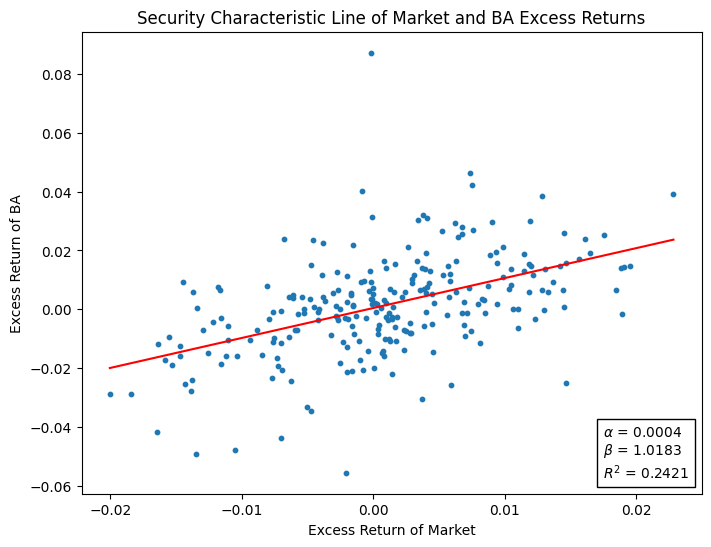

fitting regression for COST ...
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     109.1
Date:                Thu, 18 Jul 2024   Prob (F-statistic):           2.18e-21
Time:                        17:55:38   Log-Likelihood:                 793.05
No. Observations:                 249   AIC:                            -1582.
Df Residuals:                     247   BIC:                            -1575.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.001

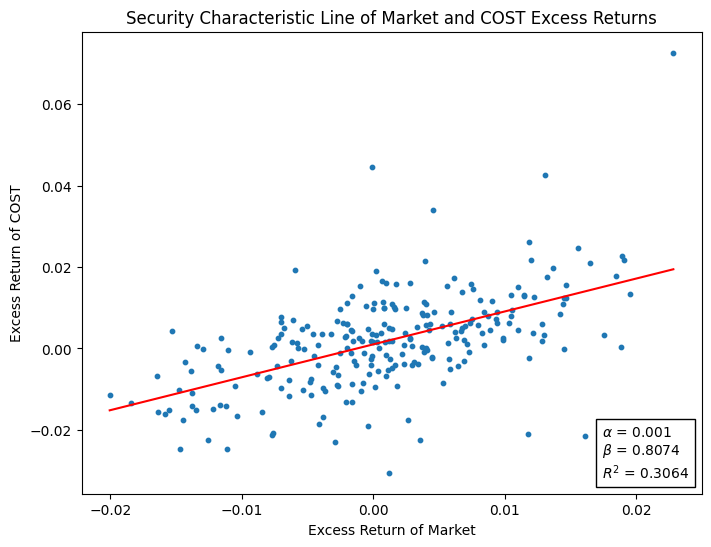

fitting regression for LMT ...
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     13.83
Date:                Thu, 18 Jul 2024   Prob (F-statistic):           0.000248
Time:                        17:55:38   Log-Likelihood:                 768.41
No. Observations:                 249   AIC:                            -1533.
Df Residuals:                     247   BIC:                            -1526.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003

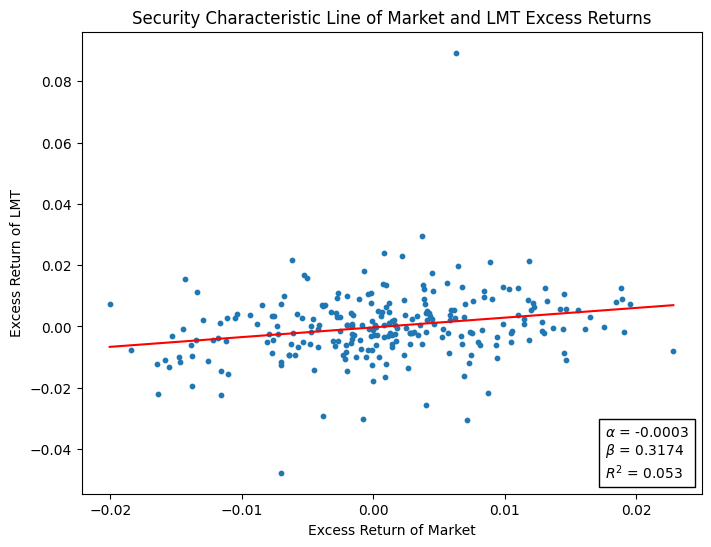

fitting regression for NVDA ...
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     108.2
Date:                Thu, 18 Jul 2024   Prob (F-statistic):           2.97e-21
Time:                        17:55:38   Log-Likelihood:                 561.23
No. Observations:                 249   AIC:                            -1118.
Df Residuals:                     247   BIC:                            -1111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.003

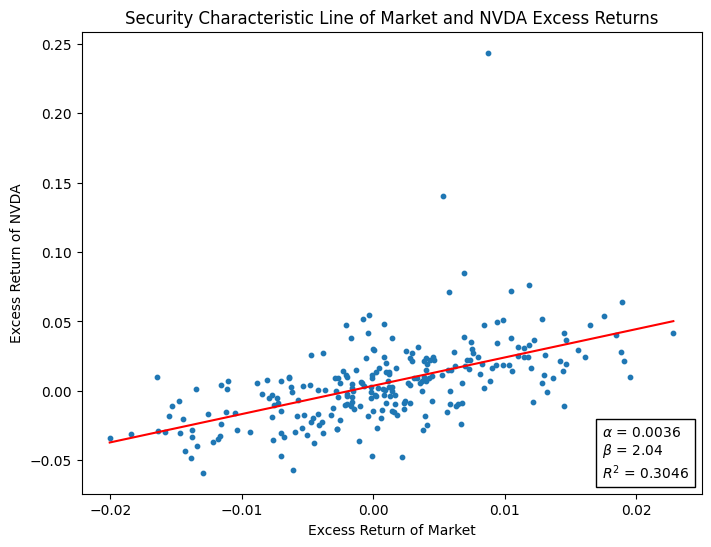

In [5]:
# risk-free rate
test_mu_f = test_mu_f['Adj Close'].values / (100 * 252)
test_mu_f = np.delete(test_mu_f, 0) 

# excess maket returns
r_m = test_market['Adj Close'].pct_change().dropna().values - (test_mu_f / (100 * 252))

for t in test_assets['Adj Close'].columns:
    # excess asset returns
    r_i = test_assets['Adj Close'][t].pct_change().dropna().values - (test_mu_f / (100 * 252))
    
    print(f'fitting regression for {t} ...')
    params = fit_regression(r_m, r_i, True)
    print(f'{params}\n')
    
    # plot
    plot_regression(r_m, r_i, params, t)

## Multiple Linear Regression

In [6]:
# get data
start = '2021-01-01'
end = '2023-12-31'

tickers = ['COST', 'NVDA', 'BA', 'LMT']

market = yf.download('^GSPC', start=start, end=end).dropna()
assets = yf.download(tickers, start=start, end=end).dropna()
risk_free = yf.download('^TNX', start=start, end=end).dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
def fit_multiple_regression(x: np.array, y: np.array, print_summary=False) -> dict:
    df = pd.DataFrame(x, columns=['R_m'])
    
    # generate time varying data
    n = len(x)
    t = np.arange(1, n+1)
    i = (t - (n+1)/2)/(n - 1)
    
    # interaction terms
    df['alpha_t'] = i
    df['beta_t'] = df['R_m'] * df['alpha_t']
    
    # fit multiple regression
    X = sm.add_constant(df)
    model = sm.OLS(y, X)
    results = model.fit()
    
    if print_summary:
        print(results.summary())

    p_alpha_t = results.pvalues['alpha_t'].round(4)
    p_beta_t = results.pvalues['beta_t'].round(4)
    
    return {'p_alpha_t': p_alpha_t, 'p_beta_t': p_beta_t}

In [8]:
# risk-free rate
risk_free = risk_free['Adj Close'].values / (100 * 252)
risk_free = np.delete(risk_free, 0) 

# excess maket returns
r_m = market['Adj Close'].pct_change().dropna().values - (risk_free / (100 * 252))

for t in assets['Adj Close'].columns:
    # excess asset returns
    r_i = assets['Adj Close'][t].pct_change().dropna().values - (risk_free / (100 * 252))
    
    print(f'fitting multiple regression for {t} ...')
    p_vals = fit_multiple_regression(r_m, r_i, True)
    print(f'{p_vals}\n')

fitting multiple regression for BA ...
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     125.5
Date:                Thu, 18 Jul 2024   Prob (F-statistic):           7.64e-66
Time:                        17:55:39   Log-Likelihood:                 1906.1
No. Observations:                 752   AIC:                            -3804.
Df Residuals:                     748   BIC:                            -3786.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

## Selecting stocks using CAPM Regression

In [9]:
# constants
P_THRESHOLD = 0.05
ALPHA_THRESHOLD = 0
BETA_THRESHOLD = 1
R_SQUARED_THRESHOLD = 0
FIT_START = '2023-01-01'
FIT_END = '2023-12-31'
MULTI_FIT_START = '2019-01-01'
MULTI_FIT_END = '2023-12-31'

In [10]:
# prepare market data
fit_df_f = yf.download('^TNX', start=FIT_START, end=FIT_END)
fit_df_m = yf.download('^GSPC', start=FIT_START, end=FIT_END)

# daily variable risk-free rate
fit_r_f = fit_df_f['Adj Close'].values / (100 * 252)
fit_r_f = np.delete(fit_r_f, 0) # drop first element to match length of market returns

# daily market returns
fit_r_m = fit_df_m['Adj Close'].pct_change().dropna().values

# daily excess returns
fit_ex_m = fit_r_m - fit_r_f

# do the same with multiple fit data
multi_fit_df_f = yf.download('^TNX', start=MULTI_FIT_START, end=MULTI_FIT_END)
multi_fit_df_m = yf.download('^GSPC', start=MULTI_FIT_START, end=MULTI_FIT_END)

multi_fit_r_f = multi_fit_df_f['Adj Close'].values / (100 * 252)
multi_fit_r_f = np.delete(multi_fit_r_f, 0) 

multi_fit_r_m = multi_fit_df_m['Adj Close'].pct_change().dropna().values

multi_fit_ex_m = multi_fit_r_m - multi_fit_r_f

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [11]:
# scrape all snp500 tickers
soup = BeautifulSoup(open('./data/scrape.html'), 'html.parser')
snp500_tickers = [a.text for a in soup.find_all('a', href=True)]

In [12]:
def select_stocks(tickers: list, ex_r_m: np.array, mu_f: np.array, test_ex_r_m: np.array, test_mu_f: np.array) -> dict:
    selected_stocks = {}
    
    for ticker in tickers:
        print(f'Processing {ticker} ...')
        
        # download ticker data
        df = yf.download(ticker, start=FIT_START, end=FIT_END)
        
        # if ticker data is not available
        if df.empty:
            continue
        
        r_i = df['Adj Close'].pct_change().dropna().values
        
        # if lengths of market and ticker data are not the same
        if len(r_i) != len(ex_r_m):
            continue
        
        ex_r_i = r_i - mu_f
                
        params = fit_regression(ex_r_m, ex_r_i)
        
        # move on to next ticker if thresholds not met
        if params['p_alpha'] > P_THRESHOLD or params['alpha'] < ALPHA_THRESHOLD:
            # the null hypothesis that alpha is 0 cannot be rejected
            continue
        
        if params['r_squared'] < R_SQUARED_THRESHOLD:
            continue
        
        # fit multiple regression to test for constant alpha
        test_df = yf.download(ticker, start=MULTI_FIT_START, end=MULTI_FIT_END)
        
        test_r_i = test_df['Adj Close'].pct_change().dropna().values
        
        # if ticker data is not same length as market data, skip
        if len(test_r_i) != len(test_ex_r_m):
            continue
        
        test_ex_r_i = test_r_i - test_mu_f
        
        p_vals = fit_multiple_regression(test_ex_r_m, test_ex_r_i)
        
        # move on if alpha is not constant
        if p_vals['p_alpha_t'] < P_THRESHOLD:
            # the null hypothesis that alpha is constant is rejected
            continue
        
        # if the stock passes all tests, add it to the selected list
        selected_stocks[ticker] = {
            'beta': params['beta'],
            'alpha': params['alpha'],
            'r_squared': params['r_squared'],
            'constant_beta': p_vals['p_beta_t'] > P_THRESHOLD
        }
    
    return selected_stocks

In [13]:
selected_stocks = select_stocks(snp500_tickers, fit_ex_m, fit_r_f, multi_fit_ex_m, multi_fit_r_f)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing AAPL ...
Processing MSFT ...
Processing NVDA ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing GOOGL ...
Processing GOOG ...
Processing AMZN ...
Processing META ...



[*********************100%%**********************]  1 of 1 completed


Processing BRK.B ...


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing LLY ...
Processing TSLA ...
Processing AVGO ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing JPM ...
Processing WMT ...
Processing V ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing XOM ...
Processing UNH ...
Processing MA ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing PG ...
Processing ORCL ...
Processing JNJ ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing COST ...
Processing HD ...
Processing BAC ...
Processing MRK ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing ABBV ...
Processing CVX ...
Processing KO ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing NFLX ...
Processing AMD ...
Processing ADBE ...
Processing CRM ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing PEP ...
Processing LIN ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing QCOM ...
Processing TMUS ...
Processing WFC ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing TMO ...
Processing ACN ...
Processing CSCO ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing TXN ...
Processing MCD ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing DHR ...
Processing AMAT ...
Processing AXP ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing INTU ...
Processing AMGN ...
Processing VZ ...



[*********************100%%**********************]  1 of 1 completed


Processing DIS ...
Processing CAT ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing ABT ...
Processing GE ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing MS ...
Processing IBM ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing PFE ...
Processing PM ...
Processing BX ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing CMCSA ...
Processing GS ...
Processing SPGI ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing NOW ...
Processing INTC ...
Processing UNP ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing ISRG ...
Processing NEE ...
Processing HON ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing UBER ...
Processing RTX ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing T ...
Processing LOW ...
Processing COP ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing BKNG ...
Processing PGR ...
Processing MU ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing TJX ...
Processing SYK ...
Processing VRTX ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing LRCX ...
Processing UPS ...
Processing C ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing ETN ...
Processing BLK ...
Processing ADI ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing ELV ...
Processing REGN ...
Processing LMT ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing PLD ...
Processing BSX ...
Processing BA ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing SCHW ...
Processing NKE ...
Processing CB ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing MMC ...
Processing KLAC ...
Processing DE ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing PANW ...
Processing ANET ...
Processing MDT ...
Processing KKR ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing ADP ...
Processing AMT ...
Processing CI ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing ABNB ...
Processing FI ...
Processing GILD ...
Processing MDLZ ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing WM ...
Processing SO ...
Processing BMY ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing SNPS ...
Processing ICE ...
Processing MO ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing HCA ...
Processing SBUX ...
Processing CRWD ...
Processing SHW ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing DUK ...
Processing MCO ...
Processing ZTS ...



[*********************100%%**********************]  1 of 1 completed


Processing CL ...
Processing GD ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing APH ...
Processing CTAS ...
Processing EOG ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing CDNS ...
Processing EQIX ...
Processing CVS ...
Processing MCK ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing FDX ...
Processing TT ...
Processing ITW ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing CMG ...
Processing CME ...
Processing NXPI ...
Processing PH ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing TGT ...
Processing PNC ...
Processing TDG ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing MAR ...
Processing SLB ...
Processing USB ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing ECL ...
Processing CSX ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing BDX ...
Processing EMR ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing FCX ...
Processing MSI ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing AON ...
Processing NOC ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing RSG ...
Processing WELL ...
Processing PYPL ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing ROP ...
Processing ORLY ...
Processing CARR ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing APD ...
Processing AJG ...
Processing CEG ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing PSX ...
Processing MPC ...
Processing PCAR ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing MMM ...
Processing DHI ...
Processing F ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing COF ...
Processing TFC ...
Processing GM ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing OXY ...
Processing NEM ...
Processing HLT ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing MET ...
Processing AFL ...
Processing PSA ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing MNST ...
Processing WMB ...
Processing ADSK ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing NSC ...
Processing AIG ...
Processing EW ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing TRV ...
Processing O ...
Processing AZO ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing DLR ...
Processing SPG ...
Processing CPRT ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing AEP ...
Processing SRE ...
Processing MCHP ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing OKE ...
Processing URI ...
Processing KMB ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing VLO ...
Processing ROST ...
Processing TEL ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing HES ...
Processing BK ...
Processing GWW ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing SMCI ...
Processing HUM ...
Processing JCI ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing KMI ...
Processing ALL ...
Processing MRNA ...
Processing LEN ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing CHTR ...
Processing CCI ...
Processing STZ ...
Processing LHX ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing PRU ...
Processing KDP ...
Processing PAYX ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing COR ...
Processing FTNT ...
Processing GEV ...


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1672549200, endDate = 1703998800")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing DXCM ...
Processing D ...
Processing ODFL ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing FIS ...
Processing RCL ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing AMP ...
Processing MPWR ...
Processing KHC ...
Processing IQV ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing CMI ...
Processing VRSK ...
Processing OTIS ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing AME ...
Processing NUE ...
Processing KR ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing IR ...
Processing MSCI ...
Processing FAST ...



[*********************100%%**********************]  1 of 1 completed


Processing FICO ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing HSY ...
Processing EA ...
Processing IDXX ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing PWR ...
Processing GLW ...
Processing DOW ...
Processing A ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing CTVA ...
Processing PCG ...
Processing CTSH ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing FANG ...
Processing SYY ...
Processing GEHC ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing ACGL ...
Processing PEG ...
Processing HPQ ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing GIS ...
Processing EXC ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing YUM ...
Processing NDAQ ...
Processing BKR ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing DFS ...
Processing IT ...
Processing EXR ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing KVUE ...
Processing CNC ...
Processing MLM ...
Processing EL ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing LULU ...
Processing VMC ...
Processing DD ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing XYL ...
Processing GRMN ...
Processing BIIB ...
Processing EFX ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing ED ...
Processing ON ...
Processing HAL ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing HWM ...
Processing ADM ...
Processing LYB ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing VICI ...
Processing CDW ...
Processing HIG ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing ROK ...
Processing XEL ...
Processing PPG ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing CSGP ...
Processing LVS ...
Processing DVN ...
Processing TRGP ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing RMD ...
Processing CBRE ...
Processing AVB ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing WAB ...
Processing TSCO ...
Processing DAL ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing MTD ...
Processing EIX ...
Processing IRM ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing MTB ...
Processing ANSS ...
Processing AWK ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing FITB ...
Processing EBAY ...
Processing WTW ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing FTV ...
Processing HPE ...
Processing DG ...
Processing VST ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing BRO ...
Processing EQR ...
Processing NVR ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing TTWO ...
Processing PHM ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing TROW ...
Processing NTAP ...
Processing WEC ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing GPN ...
Processing DOV ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing STT ...
Processing CHD ...
Processing IFF ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing KEYS ...
Processing VLTO ...
Processing SW ...


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SW']: Exception("%ticker%: Data doesn't exist for startDate = 1672549200, endDate = 1703998800")
[*********************100%%**********************]  1 of 1 completed


Processing BR ...
Processing DTE ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing ROL ...
Processing ETR ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing TER ...
Processing CAH ...
Processing AXON ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing WST ...
Processing RJF ...
Processing WDC ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing DLTR ...
Processing ZBH ...
Processing CCL ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing FSLR ...
Processing FE ...
Processing SBAC ...
Processing DECK ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing TYL ...
Processing STE ...
Processing WY ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing ARE ...
Processing INVH ...
Processing LYV ...
Processing STX ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing ES ...
Processing WRB ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing VTR ...
Processing PPL ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing TSN ...
Processing PTC ...
Processing WBD ...
Processing BF.B ...




1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-12-31)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing HBAN ...
Processing CPAY ...
Processing SYF ...
Processing LDOS ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing GDDY ...
Processing STLD ...
Processing RF ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing CTRA ...
Processing K ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing AEE ...
Processing PFG ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing MKC ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing HUBB ...
Processing CINF ...



[*********************100%%**********************]  1 of 1 completed


Processing GPC ...
Processing APTV ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing BLDR ...
Processing CBOE ...



[*********************100%%**********************]  1 of 1 completed


Processing BALL ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing BBY ...
Processing TDY ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing ALGN ...
Processing SWKS ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing ULTA ...
Processing J ...
Processing ATO ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing CFG ...
Processing CNP ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing CMS ...
Processing WAT ...
Processing ESS ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing COO ...
Processing BAX ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing HOLX ...
Processing LH ...
Processing AVY ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing OMC ...
Processing VRSN ...
Processing HRL ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing L ...
Processing TXT ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing NTRS ...
Processing EG ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing PKG ...
Processing DRI ...
Processing EXPD ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing EXPE ...
Processing CLX ...
Processing MAA ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing MOH ...
Processing FOX ...
Processing FOXA ...
Processing ZBRA ...



[*********************100%%**********************]  1 of 1 completed


Processing JBHT ...
Processing MRO ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing FDS ...
Processing LUV ...
Processing DGX ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing MAS ...
Processing GEN ...
Processing IP ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing BG ...
Processing CE ...
Processing EQT ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing IEX ...
Processing NRG ...
Processing UAL ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing NWS ...
Processing NWSA ...
Processing AMCR ...
Processing DOC ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing INCY ...
Processing ENPH ...
Processing KEY ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing AKAM ...
Processing CAG ...
Processing KIM ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing CPB ...
Processing DPZ ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing SNA ...
Processing MGM ...
Processing LNT ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing VTRS ...
Processing TRMB ...
Processing NI ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing NDSN ...
Processing UDR ...
Processing PODD ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing RVTY ...
Processing SWK ...
Processing PNR ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing CF ...
Processing AOS ...
Processing SJM ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing KMX ...
Processing JBL ...
Processing HST ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing EVRG ...
Processing POOL ...
Processing EPAM ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing BEN ...
Processing JKHY ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing REG ...
Processing AES ...
Processing JNPR ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing LKQ ...
Processing CPT ...
Processing TECH ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing APA ...
Processing DVA ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing QRVO ...
Processing EMN ...
Processing LW ...
Processing IPG ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing TAP ...
Processing CRL ...
Processing ALLE ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing ALB ...
Processing UHS ...
Processing BXP ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing HII ...
Processing RL ...
Processing CTLT ...
Processing TFX ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing FFIV ...
Processing CHRW ...
Processing WBA ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing MOS ...
Processing TPR ...
Processing GNRC ...


Processing SOLV ...


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1672549200, endDate = 1703998800")
[*********************100%%**********************]  1 of 1 completed


Processing WYNN ...
Processing PNW ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing MTCH ...
Processing FRT ...
Processing HSIC ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing PAYC ...
Processing AIZ ...
Processing BBWI ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing BIO ...
Processing NCLH ...
Processing DAY ...
Processing HAS ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Processing MKTX ...
Processing MHK ...
Processing PARA ...
Processing GL ...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing CZR ...
Processing BWA ...
Processing FMC ...



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Processing ETSY ...
Processing IVZ ...
Processing AAL ...


In [14]:
selected_stocks

{'NVDA': {'beta': 2.0404,
  'alpha': 0.0037,
  'r_squared': 0.3048,
  'constant_beta': False},
 'META': {'beta': 1.7782,
  'alpha': 0.003,
  'r_squared': 0.3426,
  'constant_beta': False},
 'GE': {'beta': 0.9313,
  'alpha': 0.0019,
  'r_squared': 0.2525,
  'constant_beta': False},
 'RCL': {'beta': 1.5745,
  'alpha': 0.0028,
  'r_squared': 0.3202,
  'constant_beta': True},
 'FICO': {'beta': 1.0147,
  'alpha': 0.0019,
  'r_squared': 0.2726,
  'constant_beta': True},
 'PHM': {'beta': 1.1971,
  'alpha': 0.0024,
  'r_squared': 0.2735,
  'constant_beta': True}}

In [15]:
selected_stocks.keys()

dict_keys(['NVDA', 'META', 'GE', 'RCL', 'FICO', 'PHM'])